In [1]:
import torch 
print(torch.cuda.device_count())


1


In [2]:
# !export CUDA_VISIBLE_DEVICES=1
# !export CUDA_LAUNCH_BLOCKING=1
import os
import torch
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
from diffusers import StableDiffusionPipeline

#  number of cuda devices
print(torch.cuda.device_count())


2024-07-26 22:59:48.725755: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 22:59:49.498673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


1


In [3]:
import model_loader
import pipeline
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

## TEXT TO IMAGE

# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "A trafic sign on a beautiful beach."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
image_path = "../images/dog.png"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.48

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

Using device: cuda


(512, 512, 3)
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512]) torch.Size([1, 4, 64, 64])


100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


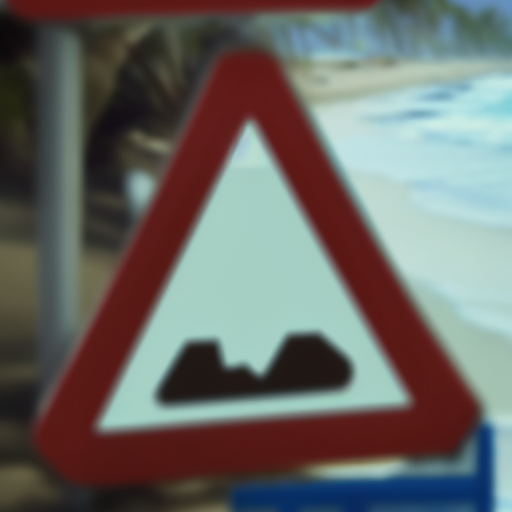

In [4]:
output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)

In [4]:
num_inference_steps = 7
from finetune import train
train(
    dataset_path="../../Training",
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cuda",
    tokenizer=tokenizer,
    epochs=1,
    batch_size=1,
    lr=1e-4,
    size=(512,512),
)


Number of images: 1
Shape of the first image: (141, 142, 3)
Number of batches: 1
Shape of the first batch: torch.Size([3, 512, 512])


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Epoch [1/1], Loss: 0.0043
Models saved to ../data/finetuned_models.ckpt


100%|██████████| 24/24 [00:04<00:00,  4.97it/s]


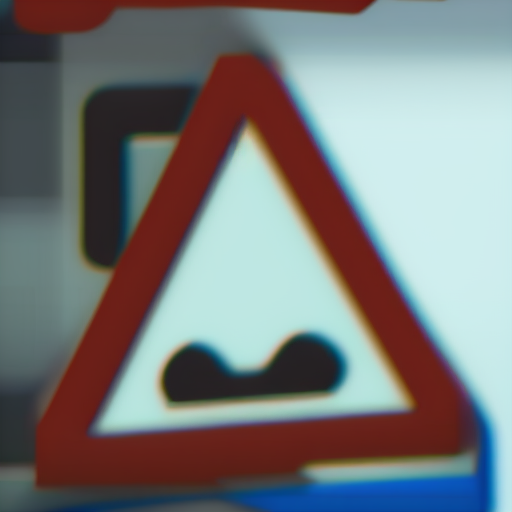

In [13]:
# path = "../data/v1-5-pruned-emaonly.ckpt"
# checkpoint = torch.load(path, map_location=DEVICE)
# model = torch.load(path)
num_inference_steps = 50
model_file = "../data/finetuned_models.ckpt"
model = torch.load(model_file, map_location=DEVICE)

prompt = "A trafic sign on a beautiful beach."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = True
cfg_scale = 8  # min: 1, max: 14

## IMAGE TO IMAGE

# Comment to disable image to image
image_path = "../images/dog.png"
input_image = Image.open(image_path)
# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.48

## SAMPLER

sampler = "ddpm"
num_inference_steps = 50
seed = 42

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)
